In [ ]:
def load_vocab(file_path):
  with open(file_path, 'r') as f:
    lines = f.readlines()
  words = sorted(set([line.strip().lower() for line in lines]))
  return words

vocabs = load_vocab('/content/vocab.txt')
vocabs

['apple',
 'book',
 'dog',
 'hello',
 'never',
 'please',
 'random',
 'sleep',
 'start',
 'understand']

In [ ]:
%pip install streamlit -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 46.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.3 MB/s eta 0:00:00


In [ ]:
%%writefile app.py
import streamlit as st

def load_vocab(file_path):
  with open(file_path, 'r') as f:
    lines = f.readlines()
  words = sorted(set([line.strip().lower() for line in lines]))
  return words

vocabs = load_vocab('/content/vocab.txt')

def levenshtein_distance(token1, token2):
  distances = [[0]*(len(token2) + 1) for _ in range(len(token1) + 1)]
  for i in range(len(token1) + 1):
    distances[i][0] = i
  for i in range(len(token2) + 1):
    distances[0][i] = i

  for t1 in range(len(token1) + 1):
    for t2 in range(len(token2) + 1):
      if token1[t1 - 1] == token2[t2 - 1]:
        distances[t1][t2] = distances[t1 - 1][t2 - 1]
      else:
        distances[t1][t2] = 1 + min(
            distances[t1][t2 - 1],
            distances[t1 - 1][t2],
            distances[t1 - 1][t2 - 1]
        )
  return distances[len(token1)][len(token2)]

def main():
  st.title("Word Correction using Levenshtein Distance")
  word = st.text_input("Word:")
  if st.button("Compute"):
    leven_dis = dict()
    for vocab in vocabs:
      leven_dis[vocab] = levenshtein_distance(word, vocab)
    sorted_dis = dict(sorted(leven_dis.items(), key = lambda item: item[1]))
    correct_word = list(sorted_dis.keys())[0]
    st.write(f"Correct word: {correct_word}")

    col1, col2 = st.columns(2)
    col1.write("Vocabulary:")
    col1.write(vocabs)

    col2.write("Distances:")
    col2.write(sorted_dis)

if __name__ == "__main__":
  main()

Overwriting app.py


In [ ]:
!npm install localtunnel

npm WARN saveError ENOENT: no such file or directory, open '/content/package.json'
npm notice created a lockfile as package-lock.json. You should commit this file.
npm WARN enoent ENOENT: no such file or directory, open '/content/package.json'
npm WARN content No description
npm WARN content No repository field.
npm WARN content No README data
npm WARN content No license field.

+ localtunnel@2.0.2
added 22 packages from 22 contributors and audited 22 packages in 1.163s

3 packages are looking for funding
  run `npm fund` for details

found 1 moderate severity vulnerability
  run `npm audit fix` to fix them, or `npm audit` for details


   ╭────────────────────────────────────────────────────────────────╮
   │                                                                │
   │      New major version of npm available! 6.14.8 → 10.8.1       │
   │   Changelog: https://github.com/npm/cli/releases/tag/v10.8.1   │
   │               Run npm install -g npm to update!                │
   │ 

In [ ]:
!streamlit run app.py &>/content/logs.txt & npx localtunnel --port 8501 & curl ipv4.icanhazip.com

34.83.106.56
npx: installed 22 in 2.087s
your url is: https://dirty-kids-double.loca.lt


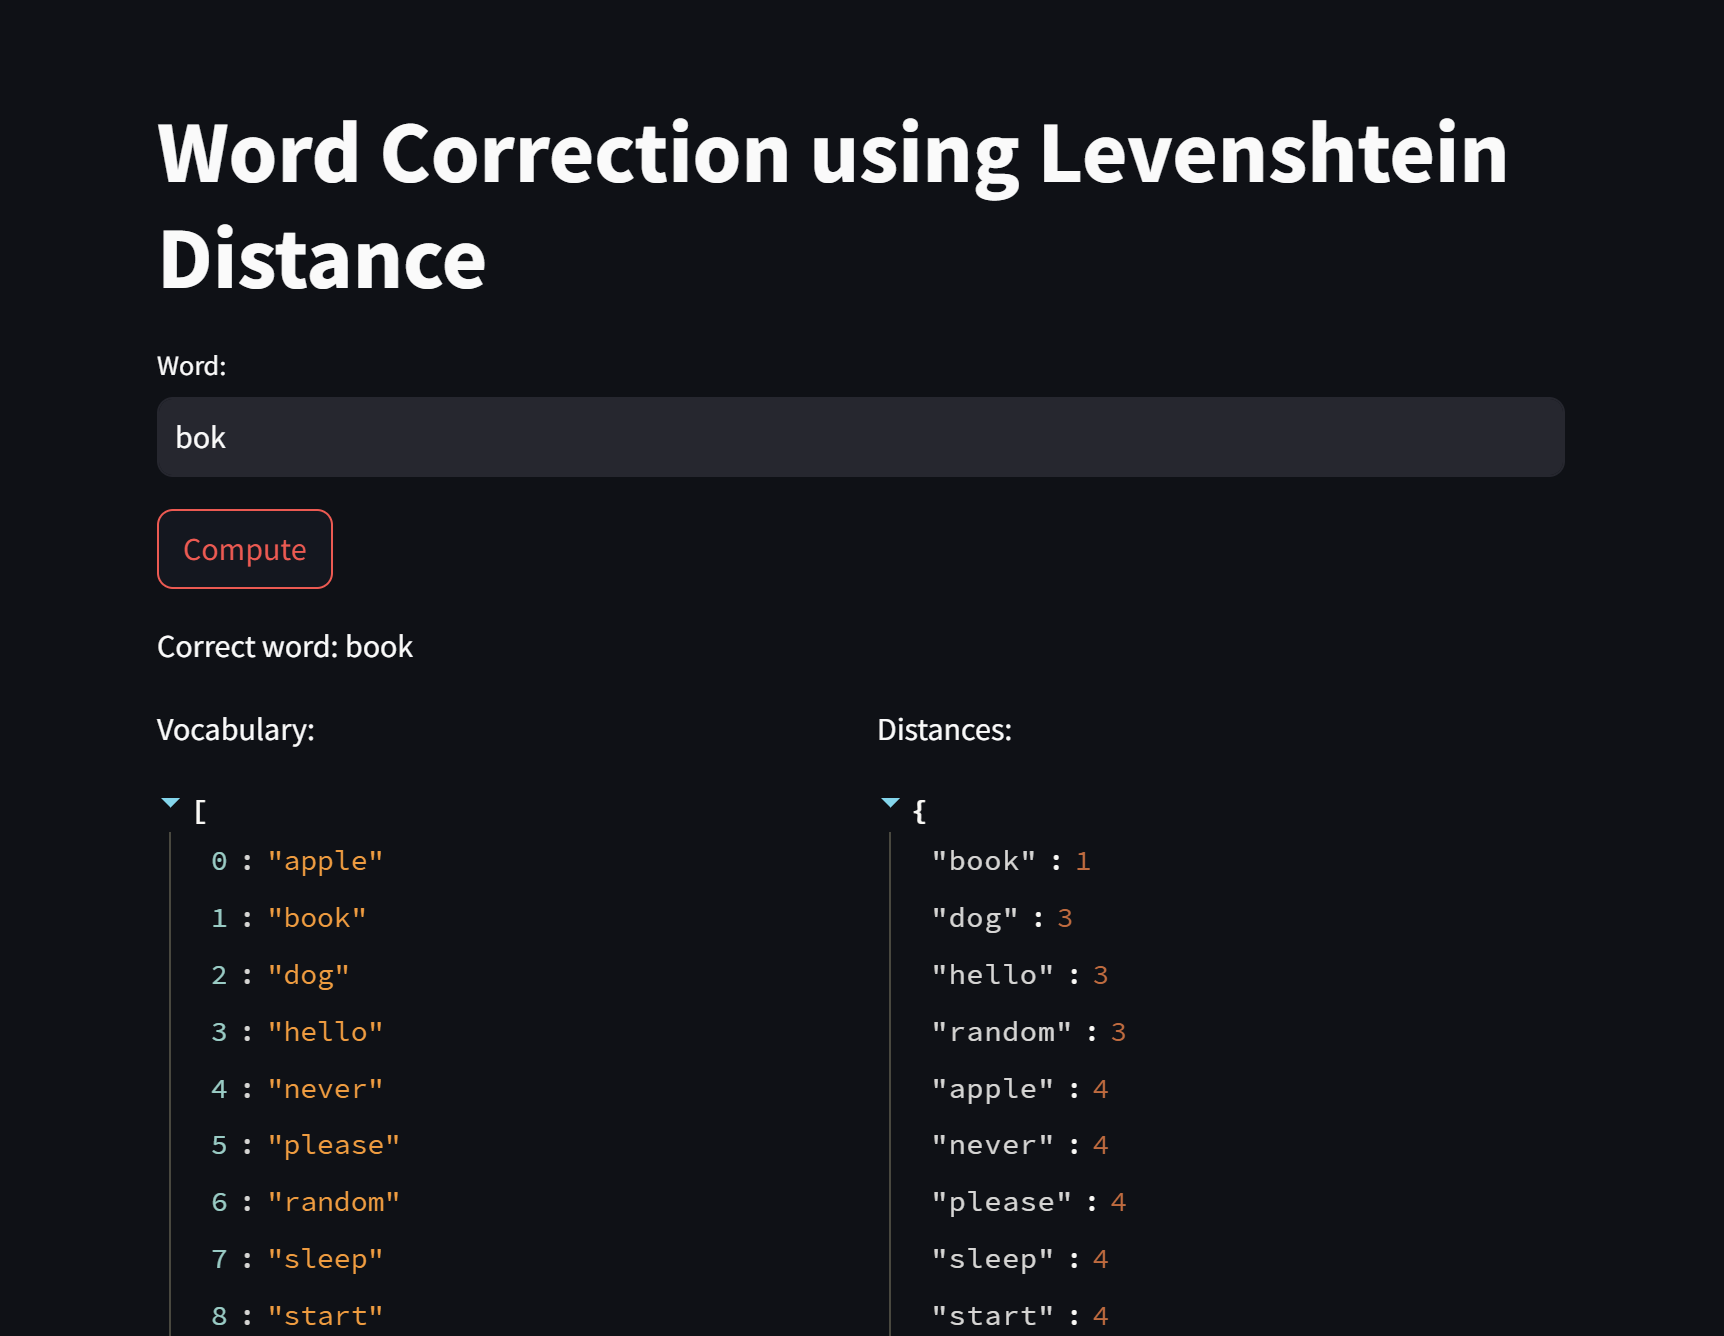

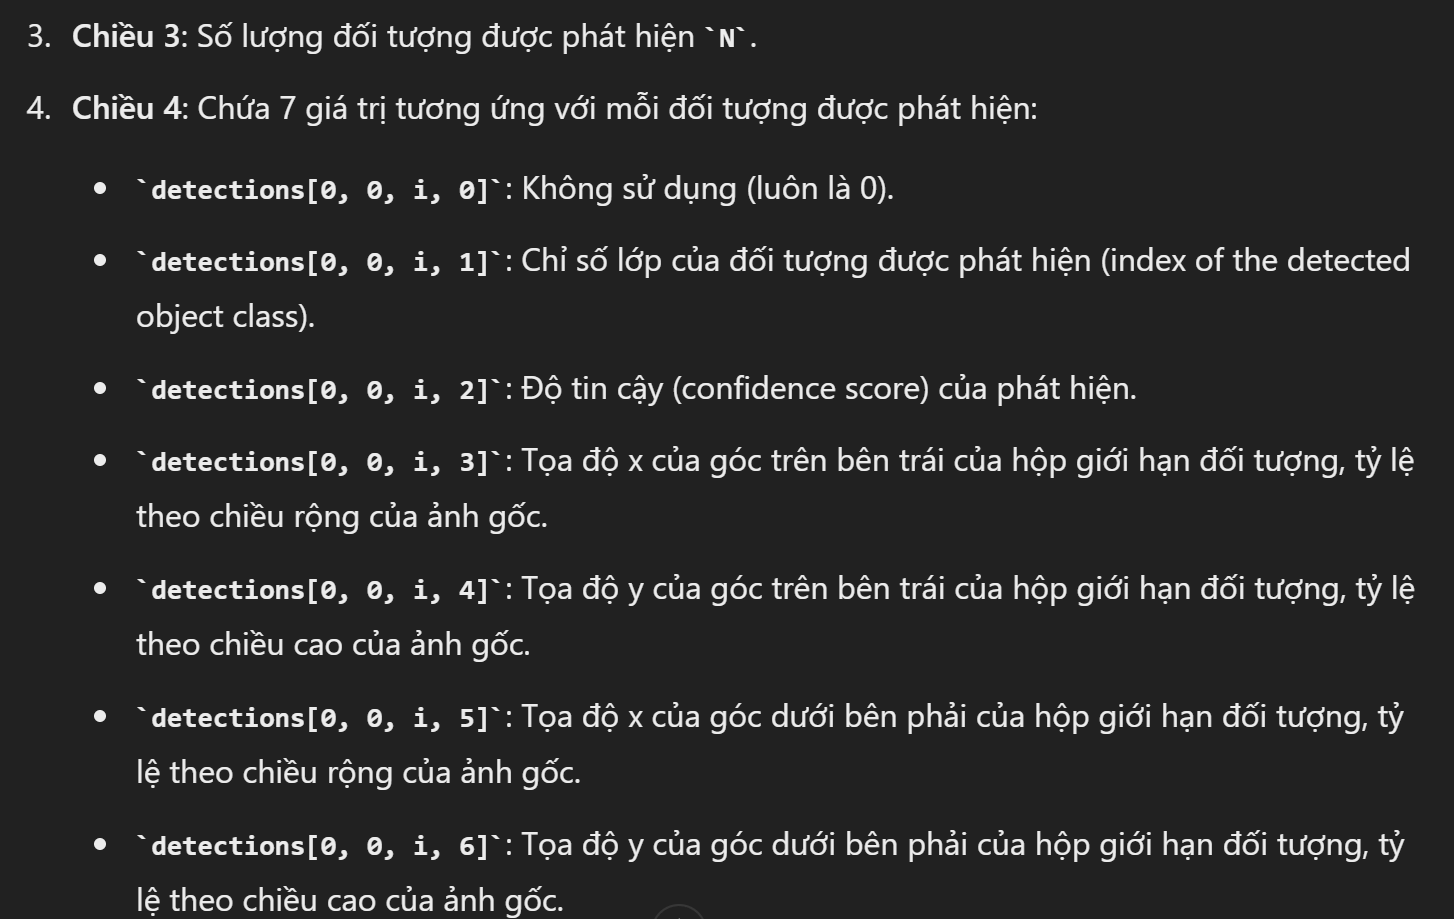

In [45]:
import cv2
from PIL import Image

MODEL = "/content/model/MobileNetSSD_deploy.caffemodel"
PROTOTXT = "/content/model/MobileNetSSD_deploy.prototxt.txt"

def process_image(image):
  blob = cv2.dnn.blobFromImage(
      cv2.resize(image, (300, 300)),
      0.007843,
      (300, 300),
      127.5
  )
  net = cv2.dnn.readNetFromCaffe(PROTOTXT, MODEL)
  net.setInput(blob)
  detections = net.forward()
  return detections

process_image(np.array(Image.open("/content/dog.jpeg")))[0, 0, 0, :]

array([ 0.        , 12.        ,  0.99918395,  0.13429624,  0.12826687,
        0.7411903 ,  0.9710435 ], dtype=float32)

In [46]:
def annotate_image(image, detections, conf_thres=0.5):
  h, w = image.shape[:2]
  for i in np.arange(0, detections.shape[2]):
    conf = detections[0, 0, i, 2]

    if conf > conf_thres:
      idx = int(detections[0, 0, i, 1])
      box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
      (startX, startY, endX, endY) = box.astype("int")
      cv2.rectangle(image, (startX, startY), (endX, endY), 70, 2)
  return image

In [47]:
%%writefile imageapp.py
import numpy as np
from PIL import Image
import streamlit as st
import cv2
from PIL import Image

MODEL = "/content/model/MobileNetSSD_deploy.caffemodel"
PROTOTXT = "/content/model/MobileNetSSD_deploy.prototxt.txt"

def process_image(image):
  blob = cv2.dnn.blobFromImage(
      cv2.resize(image, (300, 300)),
      0.007843,
      (300, 300),
      127.5
  )
  net = cv2.dnn.readNetFromCaffe(PROTOTXT, MODEL)
  net.setInput(blob)
  detections = net.forward()
  return detections

def annotate_image(image, detections, conf_thres=0.5):
  h, w = image.shape[:2]
  for i in np.arange(0, detections.shape[2]):
    conf = detections[0, 0, i, 2]

    if conf > conf_thres:
      idx = int(detections[0, 0, i, 1])
      box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
      (startX, startY, endX, endY) = box.astype("int")
      cv2.rectangle(image, (startX, startY), (endX, endY), 70, 2)
  return image

def main():
  st.title("Object Detection for Images")
  file = st.file_uploader("Upload Image", type=['jpg', 'png', 'jpeg'])
  if file is not None:
    st.image(file, caption="Uploaded Image")

    image = Image.open(file)
    image = np.array(image)
    detections = process_image(image)
    processed_image = annotate_image(image, detections)
    st.image(processed_image, caption=f"Processed Image")

if __name__ == "__main__":
  main()

Writing imageapp.py


In [48]:
!streamlit run imageapp.py &>/content/logs.txt & npx localtunnel --port 8501 & curl ipv4.icanhazip.com

34.83.106.56
npx: installed 22 in 3.76s
your url is: https://full-cycles-sniff.loca.lt


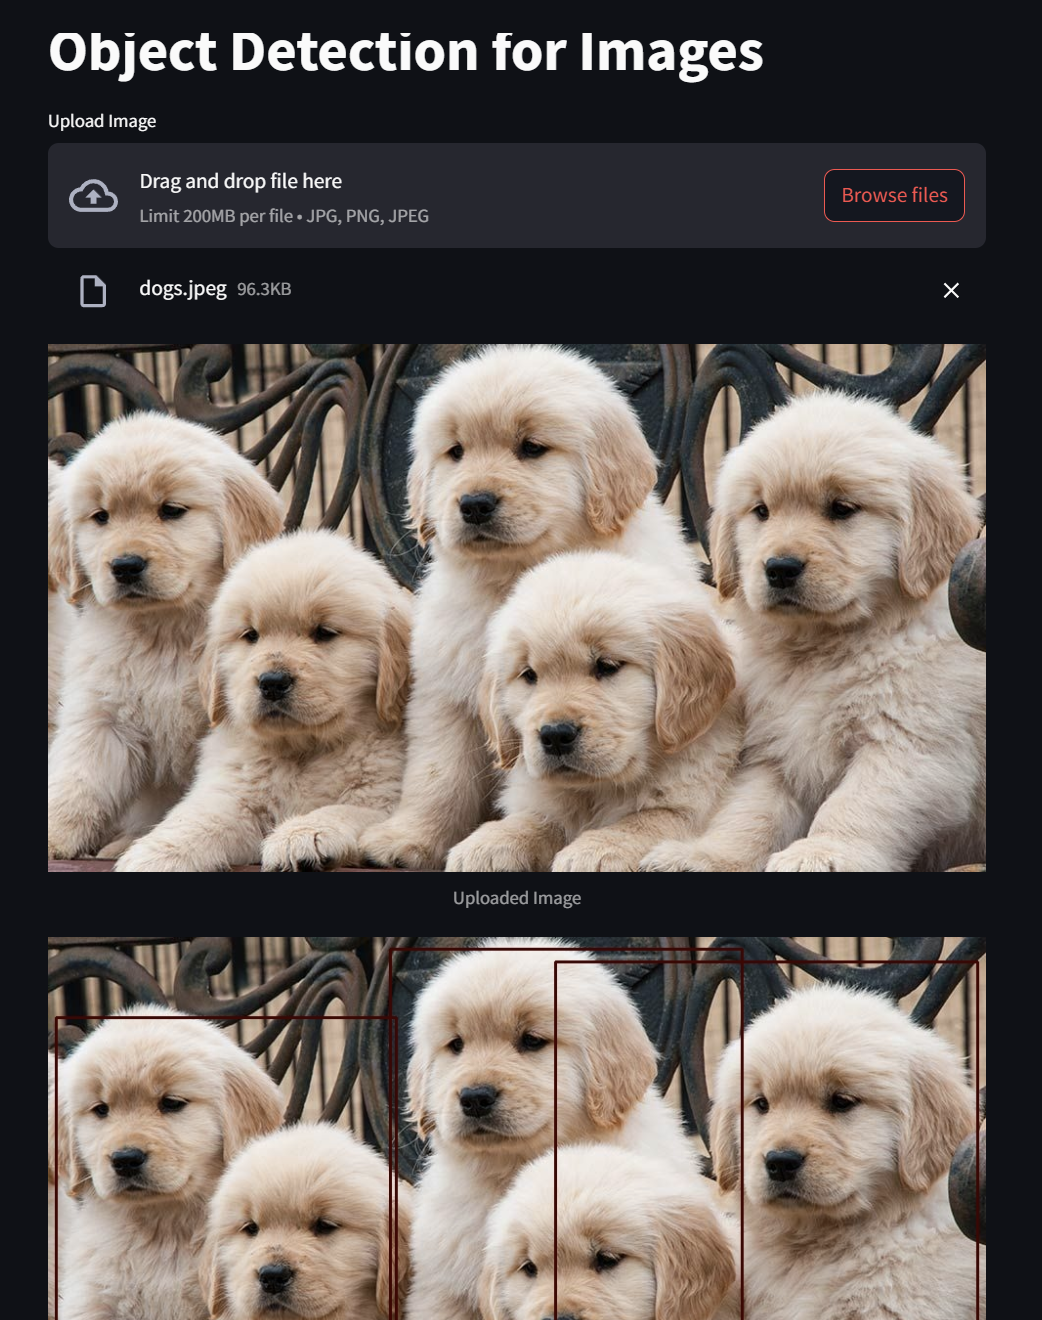

In [49]:
%pip install hugchat

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.4 MB/s eta 0:00:00


In [50]:
import streamlit as st
from hugchat import hugchat
from hugchat.login import Login

st.title("Simple Chatbot")

with st.sidebar:
  st.title("Login HugChat")
  email = st.text_input("Enter Email:")
  password = st.text_input("Enter Password:", type="password")
  if not email or not password:
    st.warning("Please enter your email and password")
  else:
    st.success("Proceed to entering your prompt message!")


In [51]:
def generate_res(prompt, email, password):
  sign = Login(email, password)
  cookies = sign.login()
  chatbot = hugchat.ChatBot(cookies=cookies.get_dict())
  return chatbot.chat(prompt)


In [70]:
%%writefile chatapp.py
import streamlit as st
from hugchat import hugchat
from hugchat.login import Login

st.title("Simple Chatbot")

def generate_res(prompt, email, password):
  sign = Login(email, password)
  cookies = sign.login()
  chatbot = hugchat.ChatBot(cookies=cookies.get_dict())
  return chatbot.chat(prompt)
def main():
  with st.sidebar:
    st.title("Login HugChat")
    email = st.text_input("Enter Email:")
    password = st.text_input("Enter Password:", type="password")
    if not email or not password:
      st.warning("Please enter your email and password")
    else:
      st.success("Proceed to entering your prompt message!")

  if "messages" not in st.session_state.keys():
    st.session_state.messages = [{
        "role": "assistant",
        "content": "How may I help you"
    }]
  for message in st.session_state.messages:
    with st.chat_message(message["role"]):
      st.write(message["content"])

  if prompt := st.chat_input(disabled= not (email and password)):
    st.session_state.messages.append({
        "role": "user",
        "content": prompt
    })
    with st.chat_message("user"):
      st.write(prompt)

    if st.session_state.messages[-1]["role"] != "assistant":
      with st.chat_message("assistant"):
        with st.spinner("Thinking..."):
          res = generate_res(prompt, email, password)
          st.write(res)
      st.session_state.messages.append({
          "role": "assistant",
          "content": res
      })


if __name__ == "__main__":
  main()

Overwriting chatapp.py


In [71]:
!streamlit run chatapp.py &>/content/logs.txt & npx localtunnel --port 8501 & curl ipv4.icanhazip.com

34.83.106.56
npx: installed 22 in 2.443s
your url is: https://crazy-brooms-smash.loca.lt


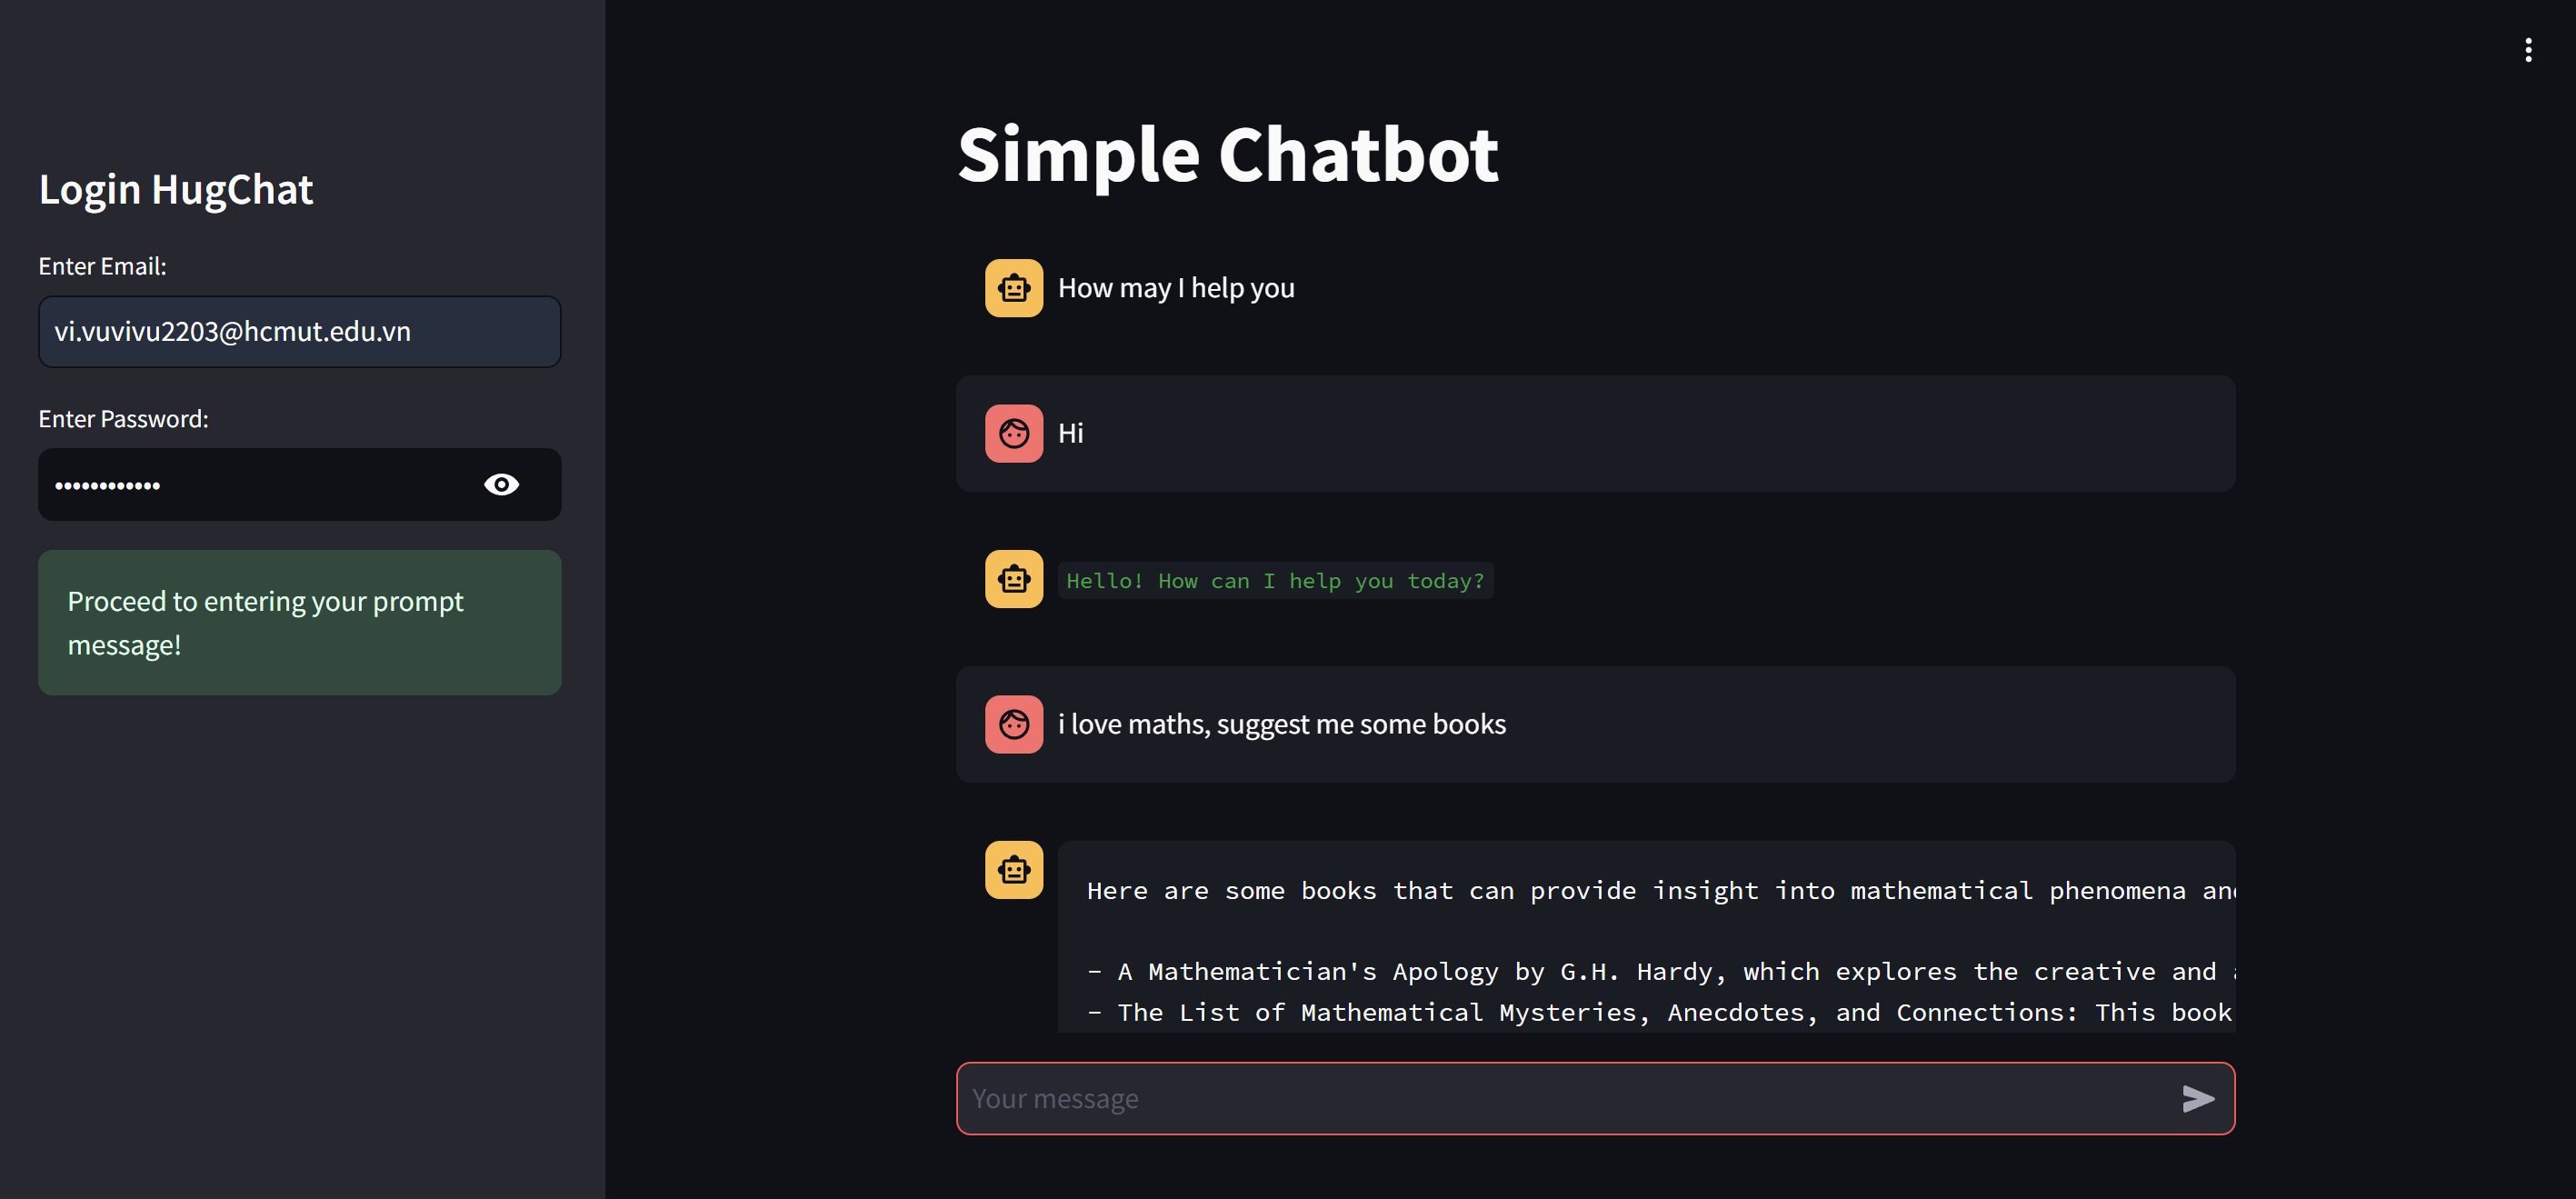